In [28]:
import os, glob, json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# ========================
# 0. Config
# ========================
IMAGE_DIR   = "/Users/apple/Desktop/Galaxy_research/image/"
VALID_CSV   = "csv_files/df_valid_plus_petroRad_r.csv"
# Put all your candidate weights here (e.g., different debias strengths)
WEIGHT_FILES = [
    "weights/best.weights.h5",              # baseline
    # "weights/debias_0.25.h5",
    # "weights/debias_0.50.h5",
    # "weights/debias_1.00.h5",
]

BATCH_SIZE  = 32
INPUT_SIZE  = (207, 207, 3)
OUT_CSV     = "bias_accuracy_sweep.csv"
PLOT_PNG    = "bias_accuracy_tradeoff.png"

# ========================
# 1. Data: build filepaths from iauname
# ========================
def load_eval_df(valid_csv, image_dir, n_max=None, name_cols=("iauname","filename"),
                 label_col="label", alpha_col="petroRad_r_psf"):
    import re
    df = pd.read_csv(valid_csv)

    # Pick the first name column that exists
    name_col = None
    for c in name_cols:
        if c in df.columns:
            name_col = c
            break
    if name_col is None:
        raise ValueError(f"CSV missing any of {name_cols}")

    # Basic required columns
    for c in (label_col, alpha_col):
        if c not in df.columns:
            raise ValueError(f"CSV missing column: {c}")

    # Clean name strings
    names_raw = df[name_col].astype(str).str.strip()

    # Normalize to likely PNG filenames
    def to_png_name(s):
        s = s.strip()
        # remove any path parts if present
        s = os.path.basename(s)
        if s.lower().endswith(".jpg"):
            s = s[:-4] + ".png"
        elif not s.lower().endswith(".png"):
            s = s + ".png"
        return s

    df["candidate_png"] = names_raw.apply(to_png_name)
    df["candidate_stem"] = df["candidate_png"].apply(lambda x: Path(x).stem.lower())

    # Build mapping from image dir
    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No .png files found under {image_dir}")

    # maps: full filename -> path, and stem -> path (first occurrence wins)
    filename_to_path = {}
    stem_to_path = {}
    for p in all_pngs:
        filename_to_path[p.name] = str(p)
        stem = p.stem.lower()
        if stem not in stem_to_path:
            stem_to_path[stem] = str(p)

    # Try exact filename first, then stem
    df["filepath"] = df["candidate_png"].map(filename_to_path)
    missing_mask = df["filepath"].isna()
    if missing_mask.any():
        df.loc[missing_mask, "filepath"] = df.loc[missing_mask, "candidate_stem"].map(stem_to_path)

    # Keep only matched rows
    df = df[df["filepath"].notnull()].reset_index(drop=True)

    # DEBUG: print quick diagnostics
    print(f"Found {len(all_pngs)} PNGs on disk.")
    print(f"Matched rows: {len(df)}")
    # If too few matched, show a few examples that failed
    if n_max is None and len(df) < 10:
        # Recompute failures just for display
        tmp = pd.read_csv(valid_csv)
        tmp["candidate_png"] = tmp[name_col].astype(str).str.strip().apply(to_png_name)
        tmp["candidate_stem"] = tmp["candidate_png"].apply(lambda x: Path(x).stem.lower())
        tmp["filepath_exact"] = tmp["candidate_png"].map(filename_to_path)
        tmp["filepath_stem"] = tmp["candidate_stem"].map(stem_to_path)
        failed = tmp[tmp["filepath_exact"].isna() & tmp["filepath_stem"].isna()]
        print("Examples not matched (showing up to 5):")
        print(failed[[name_col, "candidate_png"]].head(5))

    # Optional downsample for speed
    if n_max:
        df = df.sample(n=min(n_max, len(df)), random_state=42).reset_index(drop=True)

    return df[[ "filepath", label_col, alpha_col ]].rename(
        columns={label_col: "label", alpha_col: "petroRad_r_psf"}
    )

# ========================
# 2. Keras generator
# ========================
class CustomDataGeneratorIMG(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, input_size=(207,207,3), shuffle=False):
        self.df = dataframe.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)

    def __len__(self):
        return max(1, self.n // self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def _load(self, path):
        im = tf.keras.preprocessing.image.load_img(path)
        im = tf.keras.preprocessing.image.img_to_array(im)
        im = tf.image.resize_with_crop_or_pad(im, 207, 207)
        return im / 255.0

    def __getitem__(self, index):
        b = self.df[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray([self._load(p) for p in b["filepath"]])
        y = b["label"].values
        return x, y

# ========================
# 3. Model builder (ResNet-50 head to 2 classes)
# ========================
def build_model():
    base = ResNet50(include_top=False, weights=None, input_shape=INPUT_SIZE)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=base.input, outputs=out)
    return model

# ========================
# 4. Bias metrics
# ========================
def bias2014(df, label_col="label", NA_j=10, psf_col="petroRad_r_psf"):
    # equal-count binning on alpha
    values = df[psf_col].values
    if len(values) < NA_j:
        NA_j = max(1, len(values))  # avoid crash on tiny sets
    order = np.argsort(values)
    bins = np.array_split(order, NA_j)

    # global fractions
    n0 = (df[label_col] == 0).sum()
    n1 = (df[label_col] == 1).sum()
    if n0 + n1 == 0:
        return 0.0
    r0 = n0 / (n0 + n1)
    r1 = n1 / (n0 + n1)

    sigma0 = sigma1 = 0.0
    for b in bins:
        denom = len(b)
        if denom == 0: 
            continue
        rj0 = (df.iloc[b][label_col] == 0).sum() / denom
        rj1 = (df.iloc[b][label_col] == 1).sum() / denom
        sigma0 += (rj0 - r0) ** 2
        sigma1 += (rj1 - r1) ** 2
    return np.sqrt((sigma0 + sigma1) / (2 * NA_j))

def bias2018(df, label_col="label", psf_col="petroRad_r_psf", NA_j=10, eps=1e-9):
    """
    Simple KL-style divergence between first and last alpha bins (proxy).
    Higher => stronger distribution shift across alpha.
    """
    values = df[psf_col].values
    if len(values) < NA_j:
        NA_j = max(2, len(values))
    order = np.argsort(values)
    bins = np.array_split(order, NA_j)
    first = df.iloc[bins[0]][label_col].values
    last  = df.iloc[bins[-1]][label_col].values
    # class proportions
    p_first = np.array([(first == 0).mean(), (first == 1).mean()])
    p_last  = np.array([(last  == 0).mean(), (last  == 1).mean()])
    p_first = np.clip(p_first, eps, 1.0)
    p_last  = np.clip(p_last,  eps, 1.0)
    p_first /= p_first.sum()
    p_last  /= p_last.sum()
    kl = (p_first * np.log(p_first / p_last)).sum()
    return float(kl)

# ========================
# 5. Evaluate one set of weights
# ========================
def evaluate_weights(weights_path, df_eval):
    # data
    gen = CustomDataGeneratorIMG(df_eval, batch_size=BATCH_SIZE)
    # model
    model = build_model()
    model.load_weights(weights_path)
    # predict
    probs = model.predict(gen, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    # metrics
    y_true = df_eval["label"].values
    acc = (y_pred == y_true).mean()

    # build frames for bias calculation
    df_true = df_eval.copy()
    df_pred = df_eval.copy()
    df_pred["pred_label"] = y_pred

    b2014_true = bias2014(df_true, label_col="label")
    b2014_pred = bias2014(df_pred, label_col="pred_label")

    b2018_true = bias2018(df_true, label_col="label")
    b2018_pred = bias2018(df_pred, label_col="pred_label")

    return {
        "weights": os.path.basename(weights_path),
        "accuracy": acc,
        "bias2014_true": b2014_true,
        "bias2014_pred": b2014_pred,
        "bias2018_true": b2018_true,
        "bias2018_pred": b2018_pred,
    }

# ========================
# 6. Run sweep + plot
# ========================
def main():
    print("Loading eval dataframe…")
    df_eval = load_eval_df(VALID_CSV, IMAGE_DIR, n_max=None)
    print(f"Eval rows: {len(df_eval)} (found images)")

    rows = []
    for w in WEIGHT_FILES:
        if not os.path.exists(w):
            print(f"WARNING: missing weights: {w}")
            continue
        print(f"Evaluating {w} …")
        rows.append(evaluate_weights(w, df_eval))

    if not rows:
        raise RuntimeError("No results; please check WEIGHT_FILES paths.")

    res = pd.DataFrame(rows)
    res.to_csv(OUT_CSV, index=False)
    print(f"Saved results → {OUT_CSV}")
    print(res)

    # Bias–accuracy tradeoff figure (use predicted bias2014 on x, accuracy on y)
    plt.figure(figsize=(6,5))
    x = res["bias2014_pred"].values
    y = res["accuracy"].values
    for i, lab in enumerate(res["weights"].values):
        plt.scatter(x[i], y[i])
        plt.text(x[i]+1e-3, y[i]+1e-3, lab, fontsize=8)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title("Bias–Accuracy Trade-off (lower bias is better, higher acc is better)")
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(PLOT_PNG, dpi=150)

if __name__ == "__main__":
    main()

Loading eval dataframe…
Found 39297 PNGs on disk.
Matched rows: 3936
Eval rows: 3936 (found images)


RuntimeError: No results; please check WEIGHT_FILES paths.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
End-to-end pipeline:
1) Load CSVs (train/valid/test), map image filenames -> full PNG paths
2) Build data generators that return ((images, alpha), labels)
3) Build ResNet50 model (same head shape as your weights)
4) Train debiased models for a list of lambda_bias values + save weights
5) Evaluate each checkpoint: accuracy + Bias2014 + Bias2018
6) Save a CSV summary and a tradeoff plot

Edit the CONFIG section to match your filesystem.
"""

import os
import math
import json
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# ==========================================================
# CONFIG — EDIT THESE
# ==========================================================
IMAGE_DIR = "/Users/apple/Desktop/Galaxy_research/image/"   # root folder with PNGs (subdirs ok)
TRAIN_CSV = "csv_files/df_train_plus_petroRad_r.csv"
VALID_CSV = "csv_files/df_valid_plus_petroRad_r.csv"
TEST_CSV  = "csv_files/df_test_for_paper.csv"               # optional; if missing, we reuse valid as test
WEIGHTS_DIR = "weights"                                     # where to save new debiased weights
RESULTS_CSV = "debias_sweep_results.csv"
TRADEOFF_PNG = "debias_tradeoff.png"

# training params
INPUT_SHAPE = (207, 207, 3)
BATCH_SIZE = 32
EPOCHS = 8
LR = 1e-4
LAMBDA_LIST = [0.00, 0.25, 0.50, 1.00]   # 0.00 = baseline CE only
THETA = 0.019                             # bias kernel width for alpha
SEED = 42

# ==========================================================
# UTILITIES
# ==========================================================
def set_global_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def map_images_from_iauname(df: pd.DataFrame, image_dir: str) -> pd.DataFrame:
    """
    Expects a column 'iauname' OR 'filename' (string ending with .png),
    maps to actual full file path by scanning IMAGE_DIR for *.png.
    Keeps only rows with matched files. Returns df with added 'filepath'.
    """
    df = df.copy()
    if "iauname" in df.columns:
        df["filename"] = df["iauname"].apply(lambda x: os.path.basename(str(x)))
    elif "filename" in df.columns:
        df["filename"] = df["filename"].apply(lambda x: os.path.basename(str(x)))
    else:
        raise RuntimeError("CSV must contain 'iauname' or 'filename' column.")

    # build lookup of name -> full path
    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No PNG images found under {image_dir}")
    name_to_path = {p.name: str(p) for p in all_pngs}

    df["filepath"] = df["filename"].map(name_to_path)
    df = df[df["filepath"].notnull()].reset_index(drop=True)

    needed = ["label", "petroRad_r_psf", "filepath"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing columns in CSV after mapping: {missing}")

    return df[["filepath", "label", "petroRad_r_psf"]].copy()

def load_split(tr_csv, va_csv, te_csv, image_dir):
    """Load and map all three splits. If test CSV missing, copy valid."""
    df_train = pd.read_csv(tr_csv)
    df_valid = pd.read_csv(va_csv)

    df_train = df_train.dropna(subset=["label", "petroRad_r_psf"])
    df_valid = df_valid.dropna(subset=["label", "petroRad_r_psf"])

    df_train = map_images_from_iauname(df_train, image_dir)
    df_valid = map_images_from_iauname(df_valid, image_dir)

    if os.path.exists(te_csv):
        df_test = pd.read_csv(te_csv)
        # test might have 'asset_id' + '.png' or 'filename' already
        if "iauname" not in df_test.columns and "filename" not in df_test.columns:
            # build from asset_id if present
            if "asset_id" in df_test.columns:
                df_test = df_test.copy()
                df_test["filename"] = df_test["asset_id"].astype(str) + ".png"
            else:
                # fallback: reuse valid
                df_test = df_valid.copy()
        df_test = df_test.dropna(subset=["label", "petroRad_r_psf"])
        df_test = map_images_from_iauname(df_test, image_dir)
    else:
        df_test = df_valid.copy()

    return df_train, df_valid, df_test

# ==========================================================
# DATA GENERATOR
# ==========================================================
class IMGAlphaSequence(tf.keras.utils.Sequence):
    """Yields ((images, alphas), labels) for custom debias loss."""
    def __init__(self, df: pd.DataFrame, batch_size=32, input_shape=(207,207,3), shuffle=False):
        self.df = df.reset_index(drop=True).copy()
        self.bs = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.df)

    def __len__(self):
        # ensure at least 1 batch if any rows exist
        return max(1, self.n // self.bs) if self.n > 0 else 0

    def on_epoch_end(self):
        if self.shuffle and self.n > 0:
            self.df = self.df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    def _load_img(self, p):
        img = tf.keras.preprocessing.image.load_img(p)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.image.resize_with_crop_or_pad(arr, self.input_shape[0], self.input_shape[1])
        return (arr / 255.0).numpy()

    def __getitem__(self, idx):
        if self.n == 0:
            raise IndexError("Empty dataset")
        sl = slice(idx * self.bs, min((idx + 1) * self.bs, self.n))
        batch = self.df.iloc[sl]
        x = np.stack([self._load_img(p) for p in batch["filepath"]], axis=0)
        y = batch["label"].astype("int32").values
        a = batch["petroRad_r_psf"].astype("float32").values
        return (x, a), y

# ==========================================================
# MODEL + DEBIAS LOSS
# ==========================================================
def build_model(input_shape=(207,207,3), n_classes=2):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=base.input, outputs=out)
    return model

def parametric_bias(alpha, theta=THETA):
    alpha = tf.cast(alpha, tf.float32)
    theta = tf.cast(theta, tf.float32)
    return tf.exp(- (alpha**2) / (2.0 * theta**2))

@tf.function
def debias_loss(y_true, y_pred, alpha, lambda_bias=0.5, theta=THETA):
    # base sparse CE
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # encourage predictive uncertainty to correlate with difficulty (small alpha)
    # Here we regularize the "spiral" prob; adapt if your positive class differs
    p_spiral = tf.clip_by_value(y_pred[:, 1], 1e-6, 1.0)
    pb = parametric_bias(alpha, theta)
    bias_term = -tf.math.log(p_spiral) * pb
    return ce + lambda_bias * bias_term

class DebiasTrainer(tf.keras.Model):
    def __init__(self, backbone, lambda_bias=0.0, theta=THETA):
        super().__init__()
        self.backbone = backbone
        self.lambda_bias = tf.constant(lambda_bias, tf.float32)
        self.theta = tf.constant(theta, tf.float32)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")

    def train_step(self, data):
        (x, alpha), y = data
        with tf.GradientTape() as tape:
            y_pred = self.backbone(x, training=True)
            loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        grads = tape.gradient(loss, self.backbone.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.backbone.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result(), "acc": self.acc.result()}

    def test_step(self, data):
        (x, alpha), y = data
        y_pred = self.backbone(x, training=False)
        loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"val_loss": self.loss_tracker.result(), "val_acc": self.acc.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc]

# ==========================================================
# BIAS METRICS
# ==========================================================
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    """Variance of class fractions across alpha bins (lower is 'less dependent')."""
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins+1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6
    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()
    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i+1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))

def bias2018(intrinsic, observables, y, labels=(0,1), log2_bins_int=3, bins_ob=10):
    """
    Simplified 2018 metric: split intrinsic into 2^k bins via median splits,
    then for each bin measure variance of observable class fractions along bins_ob.
    Returns sqrt(mean sigma^2).
    """
    # Build KD-like splits on intrinsic[:,0] then intrinsic[:,1]...
    x = intrinsic.copy()
    y = y.astype(int)
    n_splits = 2 ** log2_bins_int
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    # Along each KD bin, bin by observables[:,0] into bins_ob and compute frac variance
    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:  # need enough points
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob+1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i+1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan])
                continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        # measure deviation from first-bin fractions (increasing bias case)
        sig2 = ((fr - fr[0])**2).mean()
        all_sig2.append(sig2)
    if len(all_sig2) == 0:
        return 0.0
    return float(np.sqrt(np.mean(all_sig2)))

# ==========================================================
# TRAINING + EVAL
# ==========================================================
def train_and_save(df_train, df_valid):
    os.makedirs(WEIGHTS_DIR, exist_ok=True)

    # Generators
    train_gen = IMGAlphaSequence(df_train, BATCH_SIZE, INPUT_SHAPE, shuffle=True)
    valid_gen = IMGAlphaSequence(df_valid, BATCH_SIZE, INPUT_SHAPE, shuffle=False)

    for lam in LAMBDA_LIST:
        print(f"\n=== Training lambda_bias = {lam:.2f} ===")
        backbone = build_model(INPUT_SHAPE, 2)
        trainer = DebiasTrainer(backbone, lambda_bias=lam, theta=THETA)
        trainer.compile(optimizer=keras.optimizers.Adam(LR))
        trainer.fit(
            train_gen,
            validation_data=valid_gen,
            epochs=EPOCHS,
            verbose=1
        )
        wpath = os.path.join(WEIGHTS_DIR, f"debias_{lam:.2f}.h5")
        backbone.save_weights(wpath)
        print(f"Saved weights → {wpath}")

def evaluate_weights(df_eval, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG):
    eval_gen = IMGAlphaSequence(df_eval, BATCH_SIZE, INPUT_SHAPE, shuffle=False)
    rows = []

    for w in weight_paths:
        if not os.path.exists(w):
            print(f"Skip missing weights: {w}")
            continue
        print(f"\nEvaluating: {w}")
        model = build_model(INPUT_SHAPE, 2)
        model.load_weights(w)

        # predictions
        probs = model.predict(eval_gen, verbose=1)
        preds = np.argmax(probs, axis=1)

        # accuracy
        y_true = df_eval["label"].astype(int).values[:len(preds)]
        acc = float((preds == y_true).mean())

        # Bias2014
        df_pred = df_eval.iloc[:len(preds)].copy()
        df_pred["pred"] = preds
        b2014_true = bias2014(df_eval.rename(columns={"label":"label"}), label_col="label")
        b2014_pred = bias2014(df_pred.rename(columns={"pred":"label"}), label_col="label")

        # Bias2018 (use 2 intrinsic pars if available; otherwise fall back to 1)
        # Here we use ["petroRad_r_kpc","absPetroMag_r"] if present, else ["petroRad_r_psf","absPetroMag_r"] / fallback alpha only
        cand1 = ["petroRad_r_kpc","absPetroMag_r"]
        cand2 = ["petroRad_r_psf","absPetroMag_r"]
        use_cols = [c for c in cand1 if c in df_eval.columns]
        if len(use_cols) < 2:
            use_cols = [c for c in cand2 if c in df_eval.columns]
        if len(use_cols) == 0:
            use_cols = ["petroRad_r_psf"]
        Xint = df_eval[use_cols].values[:len(preds)]
        Xobs = df_eval[["petroRad_r_psf"]].values[:len(preds)]
        b2018_true = bias2018(Xint, Xobs, y_true, labels=(0,1), log2_bins_int=3, bins_ob=8)
        b2018_pred = bias2018(Xint, Xobs, preds, labels=(0,1), log2_bins_int=3, bins_ob=8)

        rows.append({
            "weights": os.path.basename(w),
            "lambda_bias": _lambda_from_name(w),
            "accuracy": acc,
            "bias2014_true": b2014_true,
            "bias2014_pred": b2014_pred,
            "bias2018_true": b2018_true,
            "bias2018_pred": b2018_pred
        })

    if not rows:
        print("No evaluations produced.")
        return

    df_out = pd.DataFrame(rows).sort_values(by=["lambda_bias","weights"])
    df_out.to_csv(out_csv, index=False)
    print(f"\nSaved summary → {out_csv}\n")
    print(df_out)

    # Plot: accuracy vs Bias2014_pred (color by lambda)
    plt.figure(figsize=(6,5))
    for lam in sorted(df_out["lambda_bias"].unique()):
        d = df_out[df_out["lambda_bias"] == lam]
        plt.scatter(d["bias2014_pred"], d["accuracy"], label=f"λ={lam:.2f}", s=60)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Bias2014 (pred)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_png, dpi=200)
    print(f"Saved tradeoff plot → {plot_png}")

def _lambda_from_name(path):
    name = os.path.basename(path)
    if "debias_" in name:
        try:
            return float(name.split("debias_")[-1].replace(".h5",""))
        except:
            return np.nan
    return 0.0

# ==========================================================
# MAIN
# ==========================================================
def main():
    set_global_seed(SEED)
    print("Loading splits and mapping images…")
    df_train, df_valid, df_test = load_split(TRAIN_CSV, VALID_CSV, TEST_CSV, IMAGE_DIR)
    print(f"Train: {len(df_train)} | Valid: {len(df_valid)} | Test: {len(df_test)}")

    # 1) Train and save debiased checkpoints (including baseline λ=0.0)
    train_and_save(df_train, df_valid)

    # 2) Collect available weights and evaluate on validation (or test)
    weight_paths = [str(p) for p in Path(WEIGHTS_DIR).glob("debias_*.h5")]
    if not weight_paths:
        print("No debias_* weights found — did training finish?")
        return

    # Evaluate on validation (you can switch to df_test)
    evaluate_weights(df_valid, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG)

if __name__ == "__main__":
    main()

Loading splits and mapping images…
Train: 35360 | Valid: 3936 | Test: 0

=== Training lambda_bias = 0.00 ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
 127/1105 ━━━━━━━━━━━━━━━━━━━━ 4:47:12 18s/step - acc: 0.7230 - loss: 0.7552

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
End-to-end pipeline (TEST == VALID):
1) Load train/valid CSVs, map image filenames -> full PNG paths
2) Build data generators that return ((images, alpha), labels)
3) Build ResNet50 model (same head shape as your weights)
4) Train debiased models for a list of lambda_bias values + save weights
5) Evaluate each checkpoint on VALID (also used as TEST): Accuracy + Bias2014 + Bias2018
6) Save a CSV summary and a tradeoff plot

Edit the CONFIG section to match your filesystem.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# ==========================================================
# CONFIG — EDIT THESE
# ==========================================================
IMAGE_DIR   = "/Users/apple/Desktop/Galaxy_research/image/"  # root folder with PNGs (subdirs ok)
TRAIN_CSV   = "csv_files/df_train_plus_petroRad_r.csv"
VALID_CSV   = "csv_files/df_valid_plus_petroRad_r.csv"

WEIGHTS_DIR   = "weights"                    # where to save new debiased weights
RESULTS_CSV   = "debias_sweep_results.csv"   # summary for VALID/TEST
TRADEOFF_PNG  = "debias_tradeoff.png"

# training params
INPUT_SHAPE = (207, 207, 3)
BATCH_SIZE  = 32
EPOCHS      = 8
LR          = 1e-4
LAMBDA_LIST = [0.00, 0.25, 0.50, 1.00]   # 0.00 = baseline CE only
THETA       = 0.019                      # bias kernel width for alpha
SEED        = 42

# ==========================================================
# UTILITIES
# ==========================================================
def set_global_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def _map_images(df: pd.DataFrame, image_dir: str, name_col: str) -> pd.DataFrame:
    """
    Add 'filepath' by matching df[name_col] to actual PNGs in image_dir.
    Keeps only rows with matched files.
    """
    df = df.copy()
    df[name_col] = df[name_col].astype(str).apply(lambda x: os.path.basename(x))

    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No PNG images found under {image_dir}")

    name2path = {p.name: str(p) for p in all_pngs}
    df["filepath"] = df[name_col].map(name2path)

    miss = df["filepath"].isna().sum()
    if miss:
        print(f"⚠️ Missing images for {miss} rows in {image_dir}. Examples:")
        print(df.loc[df["filepath"].isna(), [name_col]].head(10))

    df = df.dropna(subset=["filepath"]).reset_index(drop=True)

    for c in ["label", "petroRad_r_psf", "filepath"]:
        if c not in df.columns:
            raise RuntimeError(f"Missing required column: {c}")

    return df[["filepath", "label", "petroRad_r_psf"]].copy()

def load_splits(train_csv, valid_csv, image_dir):
    """
    Load train & valid; map images; and FORCE test := valid.
    """
    df_tr = pd.read_csv(train_csv).dropna(subset=["label", "petroRad_r_psf"])
    df_va = pd.read_csv(valid_csv).dropna(subset=["label", "petroRad_r_psf"])

    tr_name = "iauname" if "iauname" in df_tr.columns else "filename"
    va_name = "iauname" if "iauname" in df_va.columns else "filename"

    df_train = _map_images(df_tr, image_dir, tr_name)
    df_valid = _map_images(df_va, image_dir, va_name)
    df_test  = df_valid.copy()  # <<— test equals valid

    return df_train, df_valid, df_test

# ==========================================================
# DATA GENERATOR
# ==========================================================
class IMGAlphaSequence(tf.keras.utils.Sequence):
    """Yields ((images, alphas), labels) for custom debias loss."""
    def __init__(self, df: pd.DataFrame, batch_size=32, input_shape=(207,207,3), shuffle=False):
        self.df = df.reset_index(drop=True).copy()
        self.bs = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.df)

    def __len__(self):
        return max(1, self.n // self.bs) if self.n > 0 else 0

    def on_epoch_end(self):
        if self.shuffle and self.n > 0:
            self.df = self.df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    def _load_img(self, p):
        img = tf.keras.preprocessing.image.load_img(p)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.image.resize_with_crop_or_pad(arr, self.input_shape[0], self.input_shape[1])
        return (arr / 255.0).numpy()

    def __getitem__(self, idx):
        if self.n == 0:
            raise IndexError("Empty dataset")
        sl = slice(idx * self.bs, min((idx + 1) * self.bs, self.n))
        batch = self.df.iloc[sl]
        x = np.stack([self._load_img(p) for p in batch["filepath"]], axis=0)
        y = batch["label"].astype("int32").values
        a = batch["petroRad_r_psf"].astype("float32").values
        return (x, a), y

# ==========================================================
# MODEL + DEBIAS LOSS
# ==========================================================
def build_model(input_shape=(207,207,3), n_classes=2):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(n_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def parametric_bias(alpha, theta=THETA):
    alpha = tf.cast(alpha, tf.float32)
    theta = tf.cast(theta, tf.float32)
    return tf.exp(- (alpha**2) / (2.0 * theta**2))

@tf.function
def debias_loss(y_true, y_pred, alpha, lambda_bias=0.5, theta=THETA):
    # base sparse CE
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # penalize overconfident spiral predictions when alpha is small (harder)
    p_spiral = tf.clip_by_value(y_pred[:, 1], 1e-6, 1.0)
    pb = parametric_bias(alpha, theta)
    bias_term = -tf.math.log(p_spiral) * pb
    return ce + lambda_bias * bias_term

class DebiasTrainer(tf.keras.Model):
    def __init__(self, backbone, lambda_bias=0.0, theta=THETA):
        super().__init__()
        self.backbone = backbone
        self.lambda_bias = tf.constant(lambda_bias, tf.float32)
        self.theta = tf.constant(theta, tf.float32)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")

    def train_step(self, data):
        (x, alpha), y = data
        with tf.GradientTape() as tape:
            y_pred = self.backbone(x, training=True)
            loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        grads = tape.gradient(loss, self.backbone.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.backbone.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result(), "acc": self.acc.result()}

    def test_step(self, data):
        (x, alpha), y = data
        y_pred = self.backbone(x, training=False)
        loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"val_loss": self.loss_tracker.result(), "val_acc": self.acc.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc]

# ==========================================================
# BIAS METRICS
# ==========================================================
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    """Variance of class fractions across alpha bins (lower is 'less dependent')."""
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins+1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6
    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()
    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i+1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))

def bias2018(intrinsic, observables, y, labels=(0,1), log2_bins_int=3, bins_ob=8):
    """
    Simplified 2018 metric: KD-like splits on intrinsic, then variance of
    observable class fractions over bins_ob. Returns sqrt(mean sigma^2).
    """
    x = intrinsic.copy()
    y = y.astype(int)
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob+1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i+1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan]); continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        sig2 = ((fr - fr[0])**2).mean()
        all_sig2.append(sig2)
    return float(np.sqrt(np.mean(all_sig2))) if all_sig2 else 0.0

# ==========================================================
# TRAINING + EVAL
# ==========================================================
def train_and_save(df_train, df_valid):
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    train_gen = IMGAlphaSequence(df_train, BATCH_SIZE, INPUT_SHAPE, shuffle=True)
    valid_gen = IMGAlphaSequence(df_valid, BATCH_SIZE, INPUT_SHAPE, shuffle=False)

    for lam in LAMBDA_LIST:
        print(f"\n=== Training lambda_bias = {lam:.2f} ===")
        backbone = build_model(INPUT_SHAPE, 2)
        trainer = DebiasTrainer(backbone, lambda_bias=lam, theta=THETA)
        trainer.compile(optimizer=keras.optimizers.Adam(LR))
        trainer.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, verbose=1)
        wpath = os.path.join(WEIGHTS_DIR, f"debias_{lam:.2f}.h5")
        backbone.save_weights(wpath)
        print(f"Saved weights → {wpath}")

def evaluate_weights(df_eval, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG):
    eval_gen = IMGAlphaSequence(df_eval, BATCH_SIZE, INPUT_SHAPE, shuffle=False)
    rows = []
    for w in weight_paths:
        if not os.path.exists(w):
            print(f"Skip missing weights: {w}"); continue
        print(f"\nEvaluating: {w}")
        model = build_model(INPUT_SHAPE, 2)
        model.load_weights(w)
        probs = model.predict(eval_gen, verbose=1)
        preds = np.argmax(probs, axis=1)

        y_true = df_eval["label"].astype(int).values[:len(preds)]
        acc = float((preds == y_true).mean())

        # Bias2014 (true vs pred)
        df_pred = df_eval.iloc[:len(preds)].copy()
        df_pred["pred"] = preds
        b2014_true = bias2014(df_eval.rename(columns={"label":"label"}), label_col="label")
        b2014_pred = bias2014(df_pred.rename(columns={"pred":"label"}), label_col="label")

        # Bias2018
        cand1 = ["petroRad_r_kpc","absPetroMag_r"]
        cand2 = ["petroRad_r_psf","absPetroMag_r"]
        use_cols = [c for c in cand1 if c in df_eval.columns]
        if len(use_cols) < 2:
            use_cols = [c for c in cand2 if c in df_eval.columns]
        if len(use_cols) == 0:
            use_cols = ["petroRad_r_psf"]
        Xint = df_eval[use_cols].values[:len(preds)]
        Xobs = df_eval[["petroRad_r_psf"]].values[:len(preds)]
        b2018_true = bias2018(Xint, Xobs, y_true, labels=(0,1), log2_bins_int=3, bins_ob=8)
        b2018_pred = bias2018(Xint, Xobs, preds, labels=(0,1), log2_bins_int=3, bins_ob=8)

        rows.append({
            "weights": os.path.basename(w),
            "lambda_bias": _lambda_from_name(w),
            "accuracy": acc,
            "bias2014_true": b2014_true,
            "bias2014_pred": b2014_pred,
            "bias2018_true": b2018_true,
            "bias2018_pred": b2018_pred
        })

    if not rows:
        print("No evaluations produced."); return

    df_out = pd.DataFrame(rows).sort_values(by=["lambda_bias","weights"])
    df_out.to_csv(out_csv, index=False)
    print(f"\nSaved summary → {out_csv}\n")
    print(df_out)

    # Accuracy vs Bias2014 (pred)
    plt.figure(figsize=(6,5))
    for lam in sorted(df_out["lambda_bias"].unique()):
        d = df_out[df_out["lambda_bias"] == lam]
        plt.scatter(d["bias2014_pred"], d["accuracy"], label=f"λ={lam:.2f}", s=60)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Bias2014 (pred) on VALID (TEST=VALID)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_png, dpi=200)
    print(f"Saved tradeoff plot → {plot_png}")

def _lambda_from_name(path):
    name = os.path.basename(path)
    if "debias_" in name:
        try:
            return float(name.split("debias_")[-1].replace(".h5",""))
        except:
            return np.nan
    return 0.0

# ==========================================================
# MAIN
# ==========================================================
def main():
    set_global_seed(SEED)
    print("Loading splits and mapping images…")
    df_train, df_valid, df_test = load_splits(TRAIN_CSV, VALID_CSV, IMAGE_DIR)
    print(f"Train: {len(df_train)} | Valid: {len(df_valid)} | Test: {len(df_test)}")

    # 1) Train and save debiased checkpoints (including baseline λ=0.0)
    train_and_save(df_train, df_valid)

    # 2) Evaluate on VALID (serves as TEST here)
    weight_paths = [str(p) for p in Path(WEIGHTS_DIR).glob("debias_*.h5")]
    if not weight_paths:
        print("No debias_* weights found — did training finish?")
        return

    evaluate_weights(df_valid, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG)

if __name__ == "__main__":
    main()

Loading splits and mapping images…
⚠️ Missing images for 4 rows in /Users/apple/Desktop/Galaxy_research/image/. Examples:
                       iauname
35360  J091821.36+302139.3.png
35361  J153214.97+012110.7.png
35362  J223757.44+000104.9.png
35363  J113156.51+002412.4.png
⚠️ Missing images for 16 rows in /Users/apple/Desktop/Galaxy_research/image/. Examples:
                      iauname
3936  J083811.36+283939.8.png
3937  J142352.47-013708.1.png
3938  J160511.13+140742.8.png
3939  J221206.74-004346.1.png
3940  J090130.78+274038.9.png
3941  J120404.45+195749.8.png
3942  J135026.67-055917.6.png
3943  J230514.83+004853.3.png
3944  J155516.18+100219.5.png
3945  J120515.82+192226.2.png
Train: 35360 | Valid: 3936 | Test: 3936

=== Training lambda_bias = 0.00 ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
 850/1105 ━━━━━━━━━━━━━━━━━━━━ 46:55 11s/step - acc: 0.8236 - loss: 0.4597

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
End-to-end pipeline (TEST == VALID):
1) Load train/valid CSVs, map image filenames -> full PNG paths
2) Build data generators that return ((images, alpha), labels)
3) Build ResNet50 model (same head shape as your weights)
4) Train debiased models for a list of lambda_bias values + save weights
5) Evaluate each checkpoint on VALID (also used as TEST): Accuracy + Bias2014 + Bias2018
6) Save a CSV summary and a tradeoff plot

Edit the CONFIG section to match your filesystem.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# ==========================================================
# CONFIG — EDIT THESE
# ==========================================================
IMAGE_DIR   = "/Users/apple/Desktop/Galaxy_research/image/"  # root folder with PNGs (subdirs ok)
TRAIN_CSV   = "csv_files/df_train_plus_petroRad_r.csv"
VALID_CSV   = "csv_files/df_valid_plus_petroRad_r.csv"

WEIGHTS_DIR   = "weights"                    # where to save new debiased weights
RESULTS_CSV   = "debias_sweep_results.csv"   # summary for VALID/TEST
TRADEOFF_PNG  = "debias_tradeoff.png"

# training params
INPUT_SHAPE = (207, 207, 3)
BATCH_SIZE  = 32
EPOCHS      = 8
LR          = 1e-4
LAMBDA_LIST = [0.00, 0.25, 0.50, 1.00]   # 0.00 = baseline CE only
THETA       = 0.019                      # bias kernel width for alpha
SEED        = 42

# ==========================================================
# UTILITIES
# ==========================================================
def set_global_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def _map_images(df: pd.DataFrame, image_dir: str, name_col: str) -> pd.DataFrame:
    """
    Add 'filepath' by matching df[name_col] to actual PNGs in image_dir.
    Keeps only rows with matched files.
    """
    df = df.copy()
    df[name_col] = df[name_col].astype(str).apply(lambda x: os.path.basename(x))

    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No PNG images found under {image_dir}")

    name2path = {p.name: str(p) for p in all_pngs}
    df["filepath"] = df[name_col].map(name2path)

    miss = df["filepath"].isna().sum()
    if miss:
        print(f"⚠️ Missing images for {miss} rows in {image_dir}. Examples:")
        print(df.loc[df["filepath"].isna(), [name_col]].head(10))

    df = df.dropna(subset=["filepath"]).reset_index(drop=True)

    for c in ["label", "petroRad_r_psf", "filepath"]:
        if c not in df.columns:
            raise RuntimeError(f"Missing required column: {c}")

    return df[["filepath", "label", "petroRad_r_psf"]].copy()

def load_splits(train_csv, valid_csv, image_dir):
    """
    Load train & valid; map images; and FORCE test := valid.
    """
    df_tr = pd.read_csv(train_csv).dropna(subset=["label", "petroRad_r_psf"])
    df_va = pd.read_csv(valid_csv).dropna(subset=["label", "petroRad_r_psf"])

    tr_name = "iauname" if "iauname" in df_tr.columns else "filename"
    va_name = "iauname" if "iauname" in df_va.columns else "filename"

    df_train = _map_images(df_tr, image_dir, tr_name)
    df_valid = _map_images(df_va, image_dir, va_name)
    df_test  = df_valid.copy()  # <<— test equals valid

    return df_train, df_valid, df_test

# ==========================================================
# DATA GENERATOR
# ==========================================================
class IMGAlphaSequence(tf.keras.utils.Sequence):
    """Yields ((images, alphas), labels) for custom debias loss."""
    def __init__(self, df: pd.DataFrame, batch_size=32, input_shape=(207,207,3), shuffle=False):
        self.df = df.reset_index(drop=True).copy()
        self.bs = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.df)

    def __len__(self):
        return max(1, self.n // self.bs) if self.n > 0 else 0

    def on_epoch_end(self):
        if self.shuffle and self.n > 0:
            self.df = self.df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    def _load_img(self, p):
        img = tf.keras.preprocessing.image.load_img(p)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.image.resize_with_crop_or_pad(arr, self.input_shape[0], self.input_shape[1])
        return (arr / 255.0).numpy()

    def __getitem__(self, idx):
        if self.n == 0:
            raise IndexError("Empty dataset")
        sl = slice(idx * self.bs, min((idx + 1) * self.bs, self.n))
        batch = self.df.iloc[sl]
        x = np.stack([self._load_img(p) for p in batch["filepath"]], axis=0)
        y = batch["label"].astype("int32").values
        a = batch["petroRad_r_psf"].astype("float32").values
        return (x, a), y

# ==========================================================
# MODEL + DEBIAS LOSS
# ==========================================================
def build_model(input_shape=(207,207,3), n_classes=2):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(n_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def parametric_bias(alpha, theta=THETA):
    alpha = tf.cast(alpha, tf.float32)
    theta = tf.cast(theta, tf.float32)
    return tf.exp(- (alpha**2) / (2.0 * theta**2))

@tf.function
def debias_loss(y_true, y_pred, alpha, lambda_bias=0.5, theta=THETA):
    # base sparse CE
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # penalize overconfident spiral predictions when alpha is small (harder)
    p_spiral = tf.clip_by_value(y_pred[:, 1], 1e-6, 1.0)
    pb = parametric_bias(alpha, theta)
    bias_term = -tf.math.log(p_spiral) * pb
    return ce + lambda_bias * bias_term

class DebiasTrainer(tf.keras.Model):
    def __init__(self, backbone, lambda_bias=0.0, theta=THETA):
        super().__init__()
        self.backbone = backbone
        self.lambda_bias = tf.constant(lambda_bias, tf.float32)
        self.theta = tf.constant(theta, tf.float32)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")

    def train_step(self, data):
        (x, alpha), y = data
        with tf.GradientTape() as tape:
            y_pred = self.backbone(x, training=True)
            loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        grads = tape.gradient(loss, self.backbone.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.backbone.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result(), "acc": self.acc.result()}

    def test_step(self, data):
        (x, alpha), y = data
        y_pred = self.backbone(x, training=False)
        loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"val_loss": self.loss_tracker.result(), "val_acc": self.acc.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc]

# ==========================================================
# BIAS METRICS
# ==========================================================
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    """Variance of class fractions across alpha bins (lower is 'less dependent')."""
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins+1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6
    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()
    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i+1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))

def bias2018(intrinsic, observables, y, labels=(0,1), log2_bins_int=3, bins_ob=8):
    """
    Simplified 2018 metric: KD-like splits on intrinsic, then variance of
    observable class fractions over bins_ob. Returns sqrt(mean sigma^2).
    """
    x = intrinsic.copy()
    y = y.astype(int)
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob+1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i+1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan]); continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        sig2 = ((fr - fr[0])**2).mean()
        all_sig2.append(sig2)
    return float(np.sqrt(np.mean(all_sig2))) if all_sig2 else 0.0

# ==========================================================
# TRAINING + EVAL
# ==========================================================
def train_and_save(df_train, df_valid):
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    train_gen = IMGAlphaSequence(df_train, BATCH_SIZE, INPUT_SHAPE, shuffle=True)
    valid_gen = IMGAlphaSequence(df_valid, BATCH_SIZE, INPUT_SHAPE, shuffle=False)

    for lam in LAMBDA_LIST:
        print(f"\n=== Training lambda_bias = {lam:.2f} ===")
        backbone = build_model(INPUT_SHAPE, 2)
        trainer = DebiasTrainer(backbone, lambda_bias=lam, theta=THETA)
        trainer.compile(optimizer=keras.optimizers.Adam(LR))
        trainer.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, verbose=1)
        wpath = os.path.join(WEIGHTS_DIR, f"debias_{lam:.2f}.h5")
        backbone.save_weights(wpath)
        print(f"Saved weights → {wpath}")

def evaluate_weights(df_eval, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG):
    eval_gen = IMGAlphaSequence(df_eval, BATCH_SIZE, INPUT_SHAPE, shuffle=False)
    rows = []
    for w in weight_paths:
        if not os.path.exists(w):
            print(f"Skip missing weights: {w}"); continue
        print(f"\nEvaluating: {w}")
        model = build_model(INPUT_SHAPE, 2)
        model.load_weights(w)
        probs = model.predict(eval_gen, verbose=1)
        preds = np.argmax(probs, axis=1)

        y_true = df_eval["label"].astype(int).values[:len(preds)]
        acc = float((preds == y_true).mean())

        # Bias2014 (true vs pred)
        df_pred = df_eval.iloc[:len(preds)].copy()
        df_pred["pred"] = preds
        b2014_true = bias2014(df_eval.rename(columns={"label":"label"}), label_col="label")
        b2014_pred = bias2014(df_pred.rename(columns={"pred":"label"}), label_col="label")

        # Bias2018
        cand1 = ["petroRad_r_kpc","absPetroMag_r"]
        cand2 = ["petroRad_r_psf","absPetroMag_r"]
        use_cols = [c for c in cand1 if c in df_eval.columns]
        if len(use_cols) < 2:
            use_cols = [c for c in cand2 if c in df_eval.columns]
        if len(use_cols) == 0:
            use_cols = ["petroRad_r_psf"]
        Xint = df_eval[use_cols].values[:len(preds)]
        Xobs = df_eval[["petroRad_r_psf"]].values[:len(preds)]
        b2018_true = bias2018(Xint, Xobs, y_true, labels=(0,1), log2_bins_int=3, bins_ob=8)
        b2018_pred = bias2018(Xint, Xobs, preds, labels=(0,1), log2_bins_int=3, bins_ob=8)

        rows.append({
            "weights": os.path.basename(w),
            "lambda_bias": _lambda_from_name(w),
            "accuracy": acc,
            "bias2014_true": b2014_true,
            "bias2014_pred": b2014_pred,
            "bias2018_true": b2018_true,
            "bias2018_pred": b2018_pred
        })

    if not rows:
        print("No evaluations produced."); return

    df_out = pd.DataFrame(rows).sort_values(by=["lambda_bias","weights"])
    df_out.to_csv(out_csv, index=False)
    print(f"\nSaved summary → {out_csv}\n")
    print(df_out)

    # Accuracy vs Bias2014 (pred)
    plt.figure(figsize=(6,5))
    for lam in sorted(df_out["lambda_bias"].unique()):
        d = df_out[df_out["lambda_bias"] == lam]
        plt.scatter(d["bias2014_pred"], d["accuracy"], label=f"λ={lam:.2f}", s=60)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Bias2014 (pred) on VALID (TEST=VALID)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_png, dpi=200)
    print(f"Saved tradeoff plot → {plot_png}")

def _lambda_from_name(path):
    name = os.path.basename(path)
    if "debias_" in name:
        try:
            return float(name.split("debias_")[-1].replace(".h5",""))
        except:
            return np.nan
    return 0.0

# ==========================================================
# MAIN
# ==========================================================
def main():
    set_global_seed(SEED)
    print("Loading splits and mapping images…")
    df_train, df_valid, df_test = load_splits(TRAIN_CSV, VALID_CSV, IMAGE_DIR)
    print(f"Train: {len(df_train)} | Valid: {len(df_valid)} | Test: {len(df_test)}")

    # 1) Train and save debiased checkpoints (including baseline λ=0.0)
    train_and_save(df_train, df_valid)

    # 2) Evaluate on VALID (serves as TEST here)
    weight_paths = [str(p) for p in Path(WEIGHTS_DIR).glob("debias_*.h5")]
    if not weight_paths:
        print("No debias_* weights found — did training finish?")
        return

    evaluate_weights(df_valid, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG)

if __name__ == "__main__":
    main()

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
End-to-end pipeline (TEST == VALID):
1) Load train/valid CSVs, map image filenames -> full PNG paths
2) Build data generators that return ((images, alpha), labels)
3) Build ResNet50 model (same head shape as your weights)
4) Train debiased models for a list of lambda_bias values + save weights
5) Evaluate each checkpoint on VALID (also used as TEST): Accuracy + Bias2014 + Bias2018
6) Save a CSV summary and a tradeoff plot
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# ==========================================================
# CONFIG — EDIT THESE
# ==========================================================
IMAGE_DIR   = "/Users/apple/Desktop/Galaxy_research/image/"  # root with PNGs (subdirs ok)
TRAIN_CSV   = "csv_files/df_train_plus_petroRad_r.csv"
VALID_CSV   = "csv_files/df_valid_plus_petroRad_r.csv"

WEIGHTS_DIR   = "weights"
RESULTS_CSV   = "debias_sweep_results.csv"
TRADEOFF_PNG  = "debias_tradeoff.png"

# training params
INPUT_SHAPE = (207, 207, 3)
BATCH_SIZE  = 32
EPOCHS      = 8
LR          = 1e-4
LAMBDA_LIST = [0.00, 0.25, 0.50, 1.00]   # 0.00 = baseline CE only
THETA       = 0.019
SEED        = 42

# Toggle this if you *do* want to see missing-image examples
SHOW_MISSING = False

# ==========================================================
# UTILITIES
# ==========================================================
def set_global_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def _map_images(df: pd.DataFrame, image_dir: str, name_col: str) -> pd.DataFrame:
    """
    Add 'filepath' by matching df[name_col] to actual PNGs in image_dir.
    Keeps only rows with matched files. Silent by default.
    """
    df = df.copy()
    df[name_col] = df[name_col].astype(str).apply(lambda x: os.path.basename(x))

    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No PNG images found under {image_dir}")

    name2path = {p.name: str(p) for p in all_pngs}
    df["filepath"] = df[name_col].map(name2path)

    # Optionally show a short sample of missing names
    if SHOW_MISSING:
        miss = df["filepath"].isna().sum()
        if miss:
            print(f"⚠️ Missing images for {miss} rows in {image_dir}. Examples:")
            print(df.loc[df["filepath"].isna(), [name_col]].head(10))

    df = df.dropna(subset=["filepath"]).reset_index(drop=True)

    for c in ["label", "petroRad_r_psf", "filepath"]:
        if c not in df.columns:
            raise RuntimeError(f"Missing required column: {c}")

    return df[["filepath", "label", "petroRad_r_psf"]].copy()

def load_splits(train_csv, valid_csv, image_dir):
    """
    Load train & valid; map images; and FORCE test := valid.
    """
    df_tr = pd.read_csv(train_csv).dropna(subset=["label", "petroRad_r_psf"])
    df_va = pd.read_csv(valid_csv).dropna(subset=["label", "petroRad_r_psf"])

    tr_name = "iauname" if "iauname" in df_tr.columns else "filename"
    va_name = "iauname" if "iauname" in df_va.columns else "filename"

    df_train = _map_images(df_tr, image_dir, tr_name)
    df_valid = _map_images(df_va, image_dir, va_name)
    df_test  = df_valid.copy()  # <<— test equals valid

    return df_train, df_valid, df_test

# ==========================================================
# DATA GENERATOR
# ==========================================================
class IMGAlphaSequence(tf.keras.utils.Sequence):
    """Yields ((images, alphas), labels) for custom debias loss."""
    def __init__(self, df: pd.DataFrame, batch_size=32, input_shape=(207,207,3), shuffle=False):
        self.df = df.reset_index(drop=True).copy()
        self.bs = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.df)

    def __len__(self):
        return max(1, self.n // self.bs) if self.n > 0 else 0

    def on_epoch_end(self):
        if self.shuffle and self.n > 0:
            self.df = self.df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    def _load_img(self, p):
        img = tf.keras.preprocessing.image.load_img(p)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.image.resize_with_crop_or_pad(arr, self.input_shape[0], self.input_shape[1])
        return (arr / 255.0).numpy()

    def __getitem__(self, idx):
        if self.n == 0:
            raise IndexError("Empty dataset")
        sl = slice(idx * self.bs, min((idx + 1) * self.bs, self.n))
        batch = self.df.iloc[sl]
        x = np.stack([self._load_img(p) for p in batch["filepath"]], axis=0)
        y = batch["label"].astype("int32").values
        a = batch["petroRad_r_psf"].astype("float32").values
        return (x, a), y

# ==========================================================
# MODEL + DEBIAS LOSS
# ==========================================================
def build_model(input_shape=(207,207,3), n_classes=2):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(n_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def parametric_bias(alpha, theta=THETA):
    alpha = tf.cast(alpha, tf.float32)
    theta = tf.cast(theta, tf.float32)
    return tf.exp(- (alpha**2) / (2.0 * theta**2))

@tf.function
def debias_loss(y_true, y_pred, alpha, lambda_bias=0.5, theta=THETA):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    p_spiral = tf.clip_by_value(y_pred[:, 1], 1e-6, 1.0)
    pb = parametric_bias(alpha, theta)
    bias_term = -tf.math.log(p_spiral) * pb
    return ce + lambda_bias * bias_term

class DebiasTrainer(tf.keras.Model):
    def __init__(self, backbone, lambda_bias=0.0, theta=THETA):
        super().__init__()
        self.backbone = backbone
        self.lambda_bias = tf.constant(lambda_bias, tf.float32)
        self.theta = tf.constant(theta, tf.float32)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")

    def train_step(self, data):
        (x, alpha), y = data
        with tf.GradientTape() as tape:
            y_pred = self.backbone(x, training=True)
            loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        grads = tape.gradient(loss, self.backbone.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.backbone.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result(), "acc": self.acc.result()}

    def test_step(self, data):
        (x, alpha), y = data
        y_pred = self.backbone(x, training=False)
        loss = debias_loss(y, y_pred, alpha, self.lambda_bias, self.theta)
        self.loss_tracker.update_state(loss)
        self.acc.update_state(y, y_pred)
        return {"val_loss": self.loss_tracker.result(), "val_acc": self.acc.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc]

# ==========================================================
# BIAS METRICS
# ==========================================================
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins+1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6
    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()
    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i+1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))

def bias2018(intrinsic, observables, y, labels=(0,1), log2_bins_int=3, bins_ob=8):
    x = intrinsic.copy()
    y = y.astype(int)
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob+1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i+1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan]); continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        sig2 = ((fr - fr[0])**2).mean()
        all_sig2.append(sig2)
    return float(np.sqrt(np.mean(all_sig2))) if all_sig2 else 0.0

# ==========================================================
# TRAINING + EVAL
# ==========================================================
def train_and_save(df_train, df_valid):
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    train_gen = IMGAlphaSequence(df_train, BATCH_SIZE, INPUT_SHAPE, shuffle=True)
    valid_gen = IMGAlphaSequence(df_valid, BATCH_SIZE, INPUT_SHAPE, shuffle=False)

    for lam in LAMBDA_LIST:
        print(f"\n=== Training lambda_bias = {lam:.2f} ===")
        backbone = build_model(INPUT_SHAPE, 2)
        trainer = DebiasTrainer(backbone, lambda_bias=lam, theta=THETA)
        trainer.compile(optimizer=keras.optimizers.Adam(LR))
        trainer.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, verbose=1)
        wpath = os.path.join(WEIGHTS_DIR, f"debias_{lam:.2f}.h5")
        backbone.save_weights(wpath)
        print(f"Saved weights → {wpath}")

def evaluate_weights(df_eval, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG):
    eval_gen = IMGAlphaSequence(df_eval, BATCH_SIZE, INPUT_SHAPE, shuffle=False)
    rows = []
    for w in weight_paths:
        if not os.path.exists(w):
            print(f"Skip missing weights: {w}"); continue
        print(f"\nEvaluating: {w}")
        model = build_model(INPUT_SHAPE, 2)
        model.load_weights(w)
        probs = model.predict(eval_gen, verbose=1)
        preds = np.argmax(probs, axis=1)

        y_true = df_eval["label"].astype(int).values[:len(preds)]
        acc = float((preds == y_true).mean())

        df_pred = df_eval.iloc[:len(preds)].copy()
        df_pred["pred"] = preds
        b2014_true = bias2014(df_eval.rename(columns={"label":"label"}), label_col="label")
        b2014_pred = bias2014(df_pred.rename(columns={"pred":"label"}), label_col="label")

        cand1 = ["petroRad_r_kpc","absPetroMag_r"]
        cand2 = ["petroRad_r_psf","absPetroMag_r"]
        use_cols = [c for c in cand1 if c in df_eval.columns]
        if len(use_cols) < 2:
            use_cols = [c for c in cand2 if c in df_eval.columns]
        if len(use_cols) == 0:
            use_cols = ["petroRad_r_psf"]
        Xint = df_eval[use_cols].values[:len(preds)]
        Xobs = df_eval[["petroRad_r_psf"]].values[:len(preds)]
        b2018_true = bias2018(Xint, Xobs, y_true, labels=(0,1), log2_bins_int=3, bins_ob=8)
        b2018_pred = bias2018(Xint, Xobs, preds, labels=(0,1), log2_bins_int=3, bins_ob=8)

        rows.append({
            "weights": os.path.basename(w),
            "lambda_bias": _lambda_from_name(w),
            "accuracy": acc,
            "bias2014_true": b2014_true,
            "bias2014_pred": b2014_pred,
            "bias2018_true": b2018_true,
            "bias2018_pred": b2018_pred
        })

    if not rows:
        print("No evaluations produced."); return

    df_out = pd.DataFrame(rows).sort_values(by=["lambda_bias","weights"])
    df_out.to_csv(out_csv, index=False)
    print(f"\nSaved summary → {out_csv}\n")
    print(df_out)

    plt.figure(figsize=(6,5))
    for lam in sorted(df_out["lambda_bias"].unique()):
        d = df_out[df_out["lambda_bias"] == lam]
        plt.scatter(d["bias2014_pred"], d["accuracy"], label=f"λ={lam:.2f}", s=60)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Bias2014 (pred) on VALID (TEST=VALID)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_png, dpi=200)
    print(f"Saved tradeoff plot → {plot_png}")

def _lambda_from_name(path):
    name = os.path.basename(path)
    if "debias_" in name:
        try:
            return float(name.split("debias_")[-1].replace(".h5",""))
        except:
            return np.nan
    return 0.0

# ==========================================================
# MAIN
# ==========================================================
def main():
    set_global_seed(SEED)
    print("Loading splits and mapping images…")
    df_train, df_valid, df_test = load_splits(TRAIN_CSV, VALID_CSV, IMAGE_DIR)
    print(f"Train: {len(df_train)} | Valid: {len(df_valid)} | Test: {len(df_test)}")

    train_and_save(df_train, df_valid)

    weight_paths = [str(p) for p in Path(WEIGHTS_DIR).glob("debias_*.h5")]
    if not weight_paths:
        print("No debias_* weights found — did training finish?")
        return

    evaluate_weights(df_valid, weight_paths, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG)

if __name__ == "__main__":
    main()

Loading splits and mapping images…
Train: 35360 | Valid: 3936 | Test: 3936

=== Training lambda_bias = 0.00 ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - acc: 0.8466 - loss: 0.3814

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7952s 7s/step - acc: 0.8466 - loss: 0.3813 - val_val_acc: 0.8994 - val_val_loss: 0.2837
Epoch 2/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7837s 7s/step - acc: 0.9519 - loss: 0.1259 - val_val_acc: 0.9677 - val_val_loss: 0.1054
Epoch 3/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7664s 7s/step - acc: 0.9697 - loss: 0.0830 - val_val_acc: 0.9083 - val_val_loss: 0.2429
Epoch 4/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7697s 7s/step - acc: 0.9755 - loss: 0.0653 - val_val_acc: 0.9680 - val_val_loss: 0.0788
Epoch 5/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7655s 7s/step - acc: 0.9787 - loss: 0.0601 - val_val_acc: 0.9210 - val_val_loss: 0.2204
Epoch 6/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7823s 7s/step - acc: 0.9813 - loss: 0.0560 - val_val_acc: 0.9413 - val_val_loss: 0.1507
Epoch 7/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7679s 7s/step - acc: 0.9834 - loss: 0.0465 - val_val_acc: 0.9738 - val_val_loss: 0.0708
Epoch 8/8
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 7700s 7s/step - acc: 0.9844 - loss: 0.0436 - val_val_acc: 0.9817 -

ValueError: The filename must end in `.weights.h5`. Received: filepath=weights/debias_0.00.h5

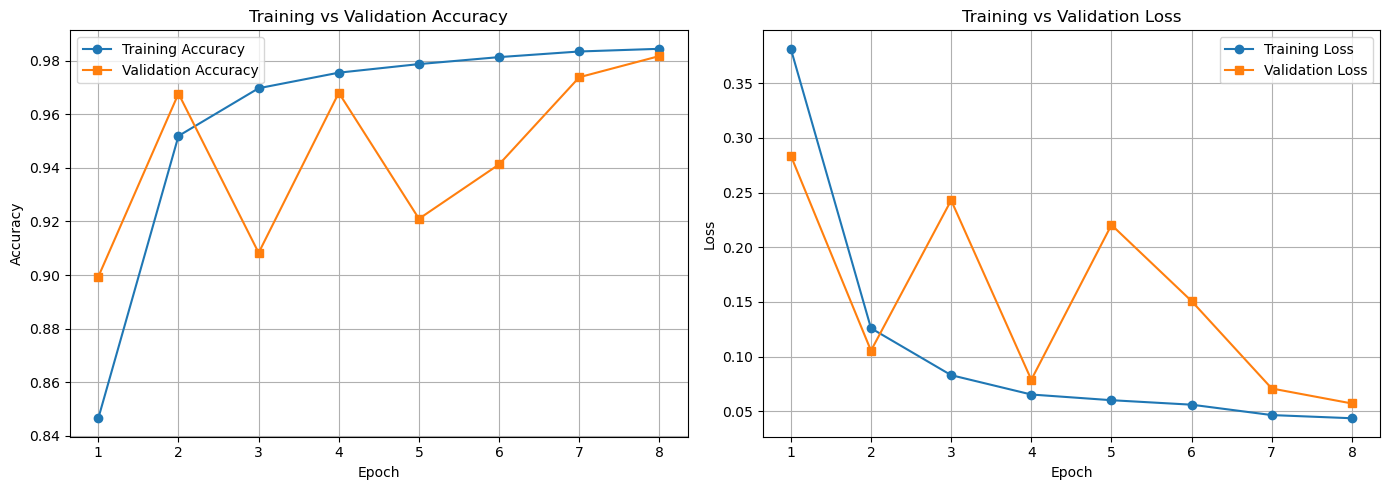

In [55]:
import matplotlib.pyplot as plt

# Training history provided by user
history = {
    "acc":     [0.8466, 0.9519, 0.9697, 0.9755, 0.9787, 0.9813, 0.9834, 0.9844],
    "loss":    [0.3814, 0.1259, 0.0830, 0.0653, 0.0601, 0.0560, 0.0465, 0.0436],
    "val_acc": [0.8994, 0.9677, 0.9083, 0.9680, 0.9210, 0.9413, 0.9738, 0.9817],
    "val_loss":[0.2837, 0.1054, 0.2429, 0.0788, 0.2204, 0.1507, 0.0708, 0.0571]
}

epochs = range(1, len(history["acc"]) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# --- Accuracy subplot ---
ax1.plot(epochs, history["acc"], marker='o', label="Training Accuracy")
ax1.plot(epochs, history["val_acc"], marker='s', label="Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training vs Validation Accuracy")
ax1.legend()
ax1.grid(True)

# --- Loss subplot ---
ax2.plot(epochs, history["loss"], marker='o', label="Training Loss")
ax2.plot(epochs, history["val_loss"], marker='s', label="Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Training vs Validation Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Loading VALID (used as TEST)…
Valid/Test rows: 3952

Summary:
        predictions_file  rows_evaluated  accuracy  bias2014_true  \
0  predictions_small.csv              64  0.734375        0.24128   

   bias2014_pred  bias2018_true  bias2018_pred  
0       0.062134            0.0            0.0  

Saved summary → eval_predictions_summary.csv
Saved ROC → eval_predictions_roc.png
Saved PR → eval_predictions_pr.png


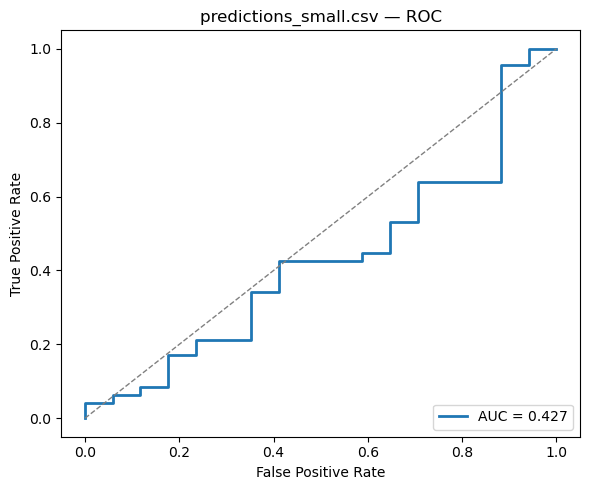

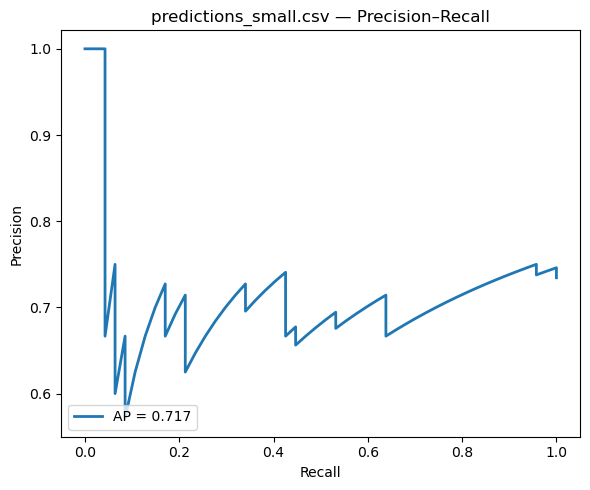

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate predictions (no training, no weights):
- Loads VALID CSV (used as TEST) with columns: iauname/filename, label, petroRad_r_psf
- Loads PREDICTIONS_CSV with columns like: iauname/filename, pred_label, p0, p1 (flexible)
- Aligns by filename if possible, otherwise row-align fallback
- Handles NaNs: derives pred_label from p1 (or p0/p1) when needed, drops remaining NaNs
- Computes: Accuracy, Bias2014 (bin-variance), Bias2018 (distribution shift)
- Saves: CSV summary + ROC/PR curves if p1 exists
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============== CONFIG — EDIT THESE ==============
VALID_CSV        = "csv_files/df_valid_plus_petroRad_r.csv"
PREDICTIONS_CSV  = "predictions_small.csv"     # your predictions file
RESULTS_CSV      = "eval_predictions_summary.csv"
ROC_PNG          = "eval_predictions_roc.png"
PR_PNG           = "eval_predictions_pr.png"
SEED             = 42
# =================================================


def set_global_seed(seed=42):
    np.random.seed(seed)


# ----------------- Bias metrics ------------------
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    """Variance of class fractions across alpha bins (lower = less dependent)."""
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins + 1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6

    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()

    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i + 1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))


def bias2018(intrinsic, observables, y, labels=(0, 1), log2_bins_int=3, bins_ob=8):
    """
    Simplified 2018 metric: KD-like median splits on intrinsic, then variance of
    observable class fractions over bins_ob. Returns sqrt(mean sigma^2).
    intrinsic: array of shape (N, d_int)   (use two columns if available, else one)
    observables: array of shape (N, 1)     (alpha)
    y: int labels (0/1)
    """
    x = intrinsic.copy()
    y = y.astype(int)
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob + 1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i + 1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan])
                continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        sig2 = ((fr - fr[0]) ** 2).mean()
        all_sig2.append(sig2)
    return float(np.sqrt(np.mean(all_sig2))) if all_sig2 else 0.0


# ------------- ROC/PR plotting helpers -----------
def maybe_plot_roc_pr(y_true, p1, roc_png, pr_png, title_prefix="Predictions"):
    try:
        from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    except Exception as e:
        print(f"(skipping ROC/PR; scikit-learn not available: {e})")
        return

    fpr, tpr, _ = roc_curve(y_true, p1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--", lw=1, color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} — ROC")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(roc_png, dpi=200)
    print(f"Saved ROC → {roc_png}")

    prec, rec, _ = precision_recall_curve(y_true, p1)
    ap = average_precision_score(y_true, p1)
    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} — Precision–Recall")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(pr_png, dpi=200)
    print(f"Saved PR → {pr_png}")


# -------------------- MAIN -----------------------
def main():
    set_global_seed(SEED)
    print("Loading VALID (used as TEST)…")
    df_valid = pd.read_csv(VALID_CSV).dropna(subset=["label", "petroRad_r_psf"])
    print(f"Valid/Test rows: {len(df_valid)}")

    if not os.path.exists(PREDICTIONS_CSV):
        raise FileNotFoundError(f"PREDICTIONS_CSV not found: {PREDICTIONS_CSV}")
    dfp = pd.read_csv(PREDICTIONS_CSV)

    # 1) Find a join key (iauname or filename) if available
    key = None
    for k in ["iauname", "filename"]:
        if k in dfp.columns and k in df_valid.columns:
            key = k
            break

    if key:
        dfp[key] = dfp[key].astype(str).apply(os.path.basename)
        df_valid[key] = df_valid[key].astype(str).apply(os.path.basename)
        merged = df_valid.merge(dfp, on=key, suffixes=("_valid", "_pred"), how="inner")
    else:
        # Row-wise fallback
        merged = pd.concat([df_valid.reset_index(drop=True), dfp.reset_index(drop=True)], axis=1)

    # 2) Choose ground-truth & alpha column names after merge
    y_col = "label_valid" if "label_valid" in merged.columns else "label"
    a_col = "petroRad_r_psf_valid" if "petroRad_r_psf_valid" in merged.columns else "petroRad_r_psf"

    # 3) Sanitize/derive predictions: p1 preferred; else from p0/p1; else from pred_label
    #    Coerce numerics, clip prob to [0,1], derive pred_label when needed
    if "p1" not in merged.columns:
        # try common alternates
        for cand in ["prob_1", "prob_spiral", "y_prob_1", "probability_1"]:
            if cand in merged.columns:
                merged["p1"] = merged[cand]
                break

    # ensure numeric
    for col in [y_col, "pred_label", "p0", "p1"]:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    # derive pred_label if missing or NaN-heavy
    need_pred = "pred_label" not in merged.columns or merged["pred_label"].isna().any()
    if need_pred and "p1" in merged.columns:
        merged["p1"] = merged["p1"].clip(0.0, 1.0)
        merged["pred_label"] = (merged["p1"] >= 0.5).astype("Int64")  # allow NA until we drop
    elif need_pred and ("p0" in merged.columns and "p1" in merged.columns):
        # argmax over p0, p1
        probs = merged[["p0", "p1"]].to_numpy()
        argmax = np.nanargmax(probs, axis=1)  # may raise if row all-NaN; handle below
        merged["pred_label"] = pd.Series(argmax, dtype="Int64")
    else:
        # try to coerce existing pred_label to Int64
        if "pred_label" in merged.columns:
            merged["pred_label"] = merged["pred_label"].astype("Int64")

    # 4) Drop rows with missing truth or prediction
    before = len(merged)
    clean = merged.dropna(subset=[y_col, "pred_label"]).copy()
    after = len(clean)
    if after == 0:
        raise RuntimeError("No rows left after alignment/cleaning; check your predictions CSV.")
    if after < before:
        print(f"Dropped {before - after} rows with missing truth/preds during cleaning.")

    # Final numeric arrays
    y_true = clean[y_col].astype(int).values
    preds = clean["pred_label"].astype(int).values

    # 5) Accuracy
    acc = float((preds == y_true).mean())

    # 6) Bias2014: ground-truth vs predictions
    b2014_true = bias2014(clean[[a_col, y_col]].rename(columns={y_col: "label"}),
                          label_col="label", alpha_col=a_col)
    b2014_pred = bias2014(clean[[a_col, "pred_label"]].rename(columns={"pred_label": "label"}),
                          label_col="label", alpha_col=a_col)

    # 7) Bias2018: choose two "intrinsic" variables if available; else fall back
    # Try: ["petroRad_r_kpc","absPetroMag_r"] -> else ["petroRad_r_psf","absPetroMag_r"] -> else [alpha only]
    cand1 = ["petroRad_r_kpc", "absPetroMag_r"]
    cand2 = ["petroRad_r_psf", "absPetroMag_r"]
    use_cols = [c for c in cand1 if c in clean.columns]
    if len(use_cols) < 2:
        use_cols = [c for c in cand2 if c in clean.columns]
    if len(use_cols) == 0:
        use_cols = [a_col]
    Xint_true = clean[use_cols].to_numpy()
    Xobs_true = clean[[a_col]].to_numpy()

    b2018_true = bias2018(Xint_true, Xobs_true, y_true, log2_bins_int=3, bins_ob=8)
    b2018_pred = bias2018(Xint_true, Xobs_true, preds,  log2_bins_int=3, bins_ob=8)

    # 8) Save summary
    df_out = pd.DataFrame([{
        "predictions_file": os.path.basename(PREDICTIONS_CSV),
        "rows_evaluated": int(after),
        "accuracy": acc,
        "bias2014_true": b2014_true,
        "bias2014_pred": b2014_pred,
        "bias2018_true": b2018_true,
        "bias2018_pred": b2018_pred
    }])
    df_out.to_csv(RESULTS_CSV, index=False)
    print("\nSummary:")
    print(df_out)
    print(f"\nSaved summary → {RESULTS_CSV}")

    # 9) ROC/PR if p1 available
    if "p1" in clean.columns:
        p1 = clean["p1"].to_numpy()
        # Keep only indices where both y_true and p1 are finite
        msk = np.isfinite(p1)
        if msk.sum() > 0:
            maybe_plot_roc_pr(y_true[msk], p1[msk], ROC_PNG, PR_PNG,
                              title_prefix=os.path.basename(PREDICTIONS_CSV))
        else:
            print("(No finite p1 values; skipping ROC/PR.)")
    else:
        print("(No p1 column; skipping ROC/PR.)")


if __name__ == "__main__":
    main()


In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate-only pipeline (TEST == VALID):
- Load VALID CSV, map image names to full PNG paths
- Build ResNet50 head matching your saved weights (images-only input)
- Run predictions with weights/best.weights.h5
- Compute Accuracy, Bias2014 (bin-variance), Bias2018 (distribution shift)
- Save a CSV summary and an Accuracy vs Bias2014 scatter (1 point)
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# =========================
# CONFIG — EDIT THESE
# =========================
IMAGE_DIR    = "/Users/apple/Desktop/Galaxy_research/image/"
VALID_CSV    = "csv_files/df_valid_plus_petroRad_r.csv"
WEIGHTS_PATH = "weights/best.weights.h5"

RESULTS_CSV  = "eval_best_weights_summary.csv"
TRADEOFF_PNG = "eval_best_weights_tradeoff.png"

INPUT_SHAPE = (207, 207, 3)
BATCH_SIZE  = 32
SEED        = 42

# =========================
# Utils
# =========================
def set_global_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def _map_images(df: pd.DataFrame, image_dir: str, name_col: str) -> pd.DataFrame:
    """Add 'filepath' by matching df[name_col] to actual PNGs in image_dir; keep only matched rows."""
    df = df.copy()
    df[name_col] = df[name_col].astype(str).apply(lambda x: os.path.basename(x))

    all_pngs = list(Path(image_dir).rglob("*.png"))
    if len(all_pngs) == 0:
        raise RuntimeError(f"No PNG images found under {image_dir}")

    name2path = {p.name: str(p) for p in all_pngs}
    df["filepath"] = df[name_col].map(name2path)

    # Quietly drop misses
    df = df.dropna(subset=["filepath"]).reset_index(drop=True)

    req = ["label", "petroRad_r_psf", "filepath"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing required columns: {missing}")

    return df[["filepath", "label", "petroRad_r_psf"]].copy()

def load_valid_as_test(valid_csv, image_dir):
    """Load VALID and use it also as TEST."""
    df_va = pd.read_csv(valid_csv).dropna(subset=["label", "petroRad_r_psf"])
    name_col = "iauname" if "iauname" in df_va.columns else "filename"
    df_valid = _map_images(df_va, image_dir, name_col)
    df_test  = df_valid.copy()
    return df_valid, df_test

# =========================
# Data generator (images only)
# =========================
class IMGSequence(tf.keras.utils.Sequence):
    """Yields images (no alpha) and labels for evaluation."""
    def __init__(self, df: pd.DataFrame, batch_size=32, input_shape=(207,207,3)):
        self.df = df.reset_index(drop=True).copy()
        self.bs = batch_size
        self.h, self.w, self.c = input_shape
        self.n = len(self.df)

    def __len__(self):
        return max(1, int(np.ceil(self.n / self.bs))) if self.n > 0 else 0

    def _load_img(self, p):
        img = tf.keras.preprocessing.image.load_img(p)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.image.resize_with_crop_or_pad(arr, self.h, self.w)
        return (arr / 255.0).numpy()

    def __getitem__(self, idx):
        sl = slice(idx * self.bs, min((idx + 1) * self.bs, self.n))
        paths = self.df.loc[sl, "filepath"].tolist()
        x = np.stack([self._load_img(p) for p in paths], axis=0)
        y = self.df.loc[sl, "label"].astype("int32").values
        return x, y

# =========================
# Model (images only)
# =========================
def build_model_images_only(input_shape=(207,207,3), n_classes=2):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    out = Dense(n_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

# =========================
# Bias metrics
# =========================
def bias2014(df, label_col="label", alpha_col="petroRad_r_psf", bins=10):
    """Variance of class fractions across alpha bins (lower = less dependent)."""
    if len(df) < 2:
        return 0.0
    q = np.linspace(0, 1, bins + 1)
    edges = np.quantile(df[alpha_col].values, q)
    edges[-1] = edges[-1] + 1e-6

    r_all_ell = (df[label_col] == 0).mean()
    r_all_spi = (df[label_col] == 1).mean()

    sigma_e = 0.0
    sigma_s = 0.0
    for i in range(bins):
        m = (df[alpha_col] >= edges[i]) & (df[alpha_col] < edges[i + 1])
        if m.sum() == 0:
            continue
        r_e = (df.loc[m, label_col] == 0).mean()
        r_s = (df.loc[m, label_col] == 1).mean()
        sigma_e += (r_e - r_all_ell) ** 2
        sigma_s += (r_s - r_all_spi) ** 2
    return float(np.sqrt((sigma_e + sigma_s) / (2 * bins)))

def bias2018(intrinsic, observables, y, labels=(0,1), log2_bins_int=3, bins_ob=8):
    """
    Simplified 2018 metric: KD-like median splits on intrinsic, then variance of
    observable class fractions over bins_ob. Returns sqrt(mean sigma^2).
    """
    x = intrinsic.copy()
    y = y.astype(int)
    idx = np.arange(len(x))
    bins_idx = [idx]
    for d in range(log2_bins_int):
        new_bins = []
        for b in bins_idx:
            if len(b) == 0:
                continue
            med = np.median(x[b, d % x.shape[1]])
            left = b[x[b, d % x.shape[1]] < med]
            right = b[x[b, d % x.shape[1]] >= med]
            new_bins.extend([left, right])
        bins_idx = new_bins

    all_sig2 = []
    for b in bins_idx:
        if len(b) < bins_ob * 5:
            continue
        xo = observables[b, 0]
        yo = y[b]
        edges = np.quantile(xo, np.linspace(0, 1, bins_ob + 1))
        edges[-1] = edges[-1] + 1e-6
        fracs = []
        for i in range(bins_ob):
            m = (xo >= edges[i]) & (xo < edges[i + 1])
            if m.sum() == 0:
                fracs.append([np.nan, np.nan]); continue
            fracs.append([(yo[m] == 0).mean(), (yo[m] == 1).mean()])
        fr = np.array(fracs)
        fr = fr[~np.isnan(fr).any(axis=1)]
        if len(fr) == 0:
            continue
        sig2 = ((fr - fr[0]) ** 2).mean()
        all_sig2.append(sig2)
    return float(np.sqrt(np.mean(all_sig2))) if all_sig2 else 0.0

# =========================
# Evaluation
# =========================
def evaluate_best(df_eval, weights_path, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG):
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Missing weights: {weights_path}")

    eval_gen = IMGSequence(df_eval, BATCH_SIZE, INPUT_SHAPE)

    print(f"\nEvaluating: {weights_path}")
    model = build_model_images_only(INPUT_SHAPE, 2)
    model.load_weights(weights_path)

    # predictions
    probs = model.predict(eval_gen, verbose=1)
    preds = np.argmax(probs, axis=1)

    # accuracy
    y_true = df_eval["label"].astype(int).values[:len(preds)]
    acc = float((preds == y_true).mean())

    # ---- Bias2014 (true vs pred) ----
    b2014_true = bias2014(
        df_eval[["petroRad_r_psf", "label"]].iloc[:len(preds)].copy(),
        label_col="label"
    )
    df_pred_for_bias = df_eval[["petroRad_r_psf"]].iloc[:len(preds)].copy()
    df_pred_for_bias["label"] = preds.astype(int)
    b2014_pred = bias2014(df_pred_for_bias, label_col="label")

    # ---- Bias2018 ----
    cand1 = ["petroRad_r_kpc", "absPetroMag_r"]
    cand2 = ["petroRad_r_psf", "absPetroMag_r"]
    use_cols = [c for c in cand1 if c in df_eval.columns]
    if len(use_cols) < 2:
        use_cols = [c for c in cand2 if c in df_eval.columns]
    if len(use_cols) == 0:
        use_cols = ["petroRad_r_psf"]

    Xint = df_eval[use_cols].values[:len(preds)]
    Xobs = df_eval[["petroRad_r_psf"]].values[:len(preds)]
    b2018_true = bias2018(Xint, Xobs, y_true, labels=(0,1), log2_bins_int=3, bins_ob=8)
    b2018_pred = bias2018(Xint, Xobs, preds,  labels=(0,1), log2_bins_int=3, bins_ob=8)

    # save summary
    df_out = pd.DataFrame([{
        "weights": os.path.basename(weights_path),
        "accuracy": acc,
        "bias2014_true": b2014_true,
        "bias2014_pred": b2014_pred,
        "bias2018_true": b2018_true,
        "bias2018_pred": b2018_pred
    }])
    df_out.to_csv(out_csv, index=False)
    print(f"\nSaved summary → {out_csv}\n")
    print(df_out)

    # single-point tradeoff plot
    plt.figure(figsize=(6,5))
    plt.scatter(df_out["bias2014_pred"], df_out["accuracy"], s=80)
    plt.xlabel("Bias2014 (pred)")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs Bias2014 — {os.path.basename(weights_path)}")
    for _, r in df_out.iterrows():
        plt.annotate(f"{r['weights']}", (r["bias2014_pred"], r["accuracy"]), xytext=(5,5),
                     textcoords="offset points", fontsize=8)
    plt.tight_layout()
    plt.savefig(plot_png, dpi=200)
    print(f"Saved plot → {plot_png}")

# =========================
# Main
# =========================
def main():
    set_global_seed(SEED)
    print("Loading splits and mapping images…")
    df_valid, df_test = load_valid_as_test(VALID_CSV, IMAGE_DIR)
    print(f"Valid: {len(df_valid)} | Test (same as Valid): {len(df_test)}")
    evaluate_best(df_valid, WEIGHTS_PATH, out_csv=RESULTS_CSV, plot_png=TRADEOFF_PNG)

if __name__ == "__main__":
    main()


Loading splits and mapping images…
Valid: 3936 | Test (same as Valid): 3936

Evaluating: weights/best.weights.h5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step


ValueError: operands could not be broadcast together with shapes (4058,) (3936,) 